<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/broadband_metalens_rcwa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


This may take a minute or two so be patient! We are continously working to optimize repository size and structure. 

In [1]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 2135, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 2135 (delta 74), reused 121 (delta 64), pack-reused 1979
Receiving objects: 100% (2135/2135), 577.07 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (653/653), done.
Checking out files: 100% (961/961), done.
Filtering content: 100% (25/25), 526.67 MiB | 88.48 MiB/s, done.


In [7]:
%cd /content/DFlat
!python setup.py develop

/content/DFlat
running develop
running egg_info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/DFlat.egg-link (link to .)
DFlat 2.0.0 is already the active version in easy-install.pth

Installed /content/DFlat
Processing dependencies for DFlat==2.0.0
Finished processing dependencies for DFlat==2.0.0


In [8]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 5.9 MB 53.2 MB/s 
     |████████████████████████████████| 438 kB 70.9 MB/s 
     |████████████████████████████████| 1.7 MB 53.7 MB/s 
     |████████████████████████████████| 578.0 MB 18 kB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=693496958f518c7c928d076c0a25a482f4d2be7f7e1c0e99699b323dd9dd8220
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-

# Create a general optimization pipeline using the psf layer and the rcwa optical model 

A general class like this may be reused/recalled with different inputs or even different loss functions. It is a useful starting point when designing an optimization graph. 

First, we import the required modules from the DFlat repository. These contain packaged routines that are compatible with tf.keras

In [10]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy

import dflat.data_structure as df_struct
import dflat.optimization_helpers as df_optimizer
import dflat.physical_optical_layer as df_physical
import dflat.fourier_layer as df_fourier
import dflat.tools as df_tools

# Here we explicitly call the cell assembly function used internally in the rcwa
# engine since we may want to look at the structure layers we are assembling
from dflat.physical_optical_layer.core.ms_parameterization import generate_cell_perm


We first build an optimization class inheriting from the df_optimizer.Pipeline_Object (although you can choose to not use this).

By inheriting this class, all the details of saving and loading custom model checkpoints are taken care of. Moreover, this class allows us to use convenient, pre-written functions for training loops, enabling faster prototyping.  

Most of the lines below are used to define the visualizeTrainingCheckpoint. This is a plotting functions that will be called during save checkpoints (intermediary epochs) to monitor the process when using the training helpers in the df_optimizer module! Defining this function overides the parent empy function and is entirely optional! If not included, no visualization plots will be made but the code will still run.

In the collab, these plots wont actually save since no google drive or harddrive is mounted but that is okay! we can always view plots manually at the end by tweaking the code and calling the function with plt.show()

In [12]:
class pipeline_metalens_rcwa(df_optimizer.Pipeline_Object):
    def __init__(self, rcwa_parameters, propagation_parameters, point_source_locs, savepath, saveAtEpochs=None):
        super(pipeline_metalens_rcwa, self).__init__(savepath, saveAtEpochs)

        # Add the input simulation parameters to the class attributes
        self.rcwa_parameters = rcwa_parameters
        self.propagation_parameters = propagation_parameters
        self.point_source_locs = point_source_locs

        # define computational layers
        self.rcwa_latent_layer = df_physical.RCWA_Latent_Layer(self.rcwa_parameters)
        self.psf_layer = df_fourier.PSF_Layer(propagation_parameters)

        # Make uniform state latent tensor as initial variable for metasurface with helper function
        input_shape = self.rcwa_latent_layer.shape_vect_size
        init_latent = 0.25 * tf.ones(shape=input_shape)
        self.latent_tensor_variable = tf.Variable(
            init_latent, trainable=True, dtype=tf.float32, name="metasurface_latent_tensor"
        )

    def __call__(self):
        out = self.rcwa_latent_layer(self.latent_tensor_variable)
        psf_intensity, _ = self.psf_layer(out, self.point_source_locs, batch_loop=False)

        # sum over the two polarization basis (x and y linear)
        psf_intensity = tf.reduce_sum(psf_intensity, axis=1)

        self.last_lens = out
        self.last_psf = psf_intensity

        return psf_intensity

    def visualizeTrainingCheckpoint(self, saveto, showPlot=False):
        # This overrides the baseclass visualization call function, called during checkpoints

        savefigpath = self.savepath + "/trainingOutput/"
        sim_wavelengths = self.propagation_parameters["wavelength_set_m"]
        num_wl = len(sim_wavelengths)

        xl, yl = df_fourier.getCoordinates_vector(
            self.propagation_parameters["ms_samplesM"],
            self.propagation_parameters["ms_dx_m"],
            True,
            tf.float32,
        )
        xd, yd = df_fourier.getCoordinates_vector(
            self.propagation_parameters["sensor_pixel_number"],
            self.propagation_parameters["sensor_pixel_size_m"],
            False,
            tf.float32,
        )

        Lx = self.rcwa_parameters["Lx"]
        Ly = self.rcwa_parameters["Ly"]

        # Display the learned phase and transmission profile on first row
        # and wavelength dependent PSFs on the second
        trans = self.last_lens[0]
        phase = self.last_lens[1]

        fig = plt.figure(figsize=(30, 20))
        ax = df_tools.addAxis(fig, 2, num_wl)
        for i in range(num_wl):
            ax[i].plot(xl[0, :] * 1e6, phase[i, 0, 0, :], "k--")
            ax[i].plot(xl[0, :] * 1e6, phase[i, 1, 0, :], "b--")
            ax[i].plot(xl[0, :] * 1e6, trans[i, 0, 0, :], "k*")
            ax[i].plot(xl[0, :] * 1e6, trans[i, 1, 0, :], "b*")
            df_tools.formatPlots(
                fig,
                ax[i],
                None,
                xlabel="Lens r (um)",
                ylabel="Phase and Transmission" if i == 0 else "",
                title="wavelength: " + f"{sim_wavelengths[i]*1e9:3.0f}",
            )

            ax[i + num_wl].imshow(
                self.last_psf[i, 0, :, :],
                extent=(np.min(xd) * 1e6, np.max(xd) * 1e6, np.min(yd) * 1e6, np.max(yd) * 1e6),
            )
            df_tools.formatPlots(fig, ax[i + num_wl], None, xlabel="det x (um)", ylabel="det y (um)")
        
        if not showPlot:
          plt.savefig(savefigpath + "png_images/" + saveto + "epoch_Lens.png")
          plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_Lens.pdf")
          plt.close()

        # Display some of the learned metacells
        latent_tensor_state = self.get_variable_by_name("metasurface_latent_tensor")[0]
        norm_shape_param = df_tools.latent_to_param(latent_tensor_state)
        ER, _ = generate_cell_perm(norm_shape_param, self.rcwa_parameters)
 
        disp_num = 5
        cell_idx = np.linspace(0, ER.shape[1] - 1, disp_num).astype(int)
        fig = plt.figure(figsize=(35, 7))
        ax = df_tools.addAxis(fig, 1, disp_num)
        for i, idx in enumerate(cell_idx):
            ax[i].imshow(
                np.abs(ER[0, idx, 0, 0, :, :]), extent=(np.min(0), np.max(Lx) * 1e9, np.min(0), np.max(Ly) * 1e9)
            )
            df_tools.formatPlots(
                fig,
                ax[i],
                None,
                xlabel="Cell x (nm)",
                ylabel="Cell y (nm)" if i == 0 else "",
                title="Lens r (um): " + f"{xl[0,idx]*1e6:3.0f}",
            )
        if not showPlot:
          plt.savefig(savefigpath + "png_images/" + saveto + "epoch_Cells.png")
          plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_Cells.pdf")
          plt.close()

        return


# Define Simulation Settings and run the optimization

We can now create a function that initializes our simulation setting and passes it to the newly initialized optimization pipeline. 

This pipeline can be trained easily since it is compatible with DFlats df_optimizer.run_pipeline_optimization() routine. This routine takes in a class that inherits df_optimizer.Pipeline_Object like done above.  

To train with this call, we define a loss function. Below, this is done in loss_fn. Note that currently when using this approach, the loss function can only take "pipeline_output" as an input! This means that the loss function should be defined explicitly in terms of the pipeline call function (or be defined inside the call function) so the output is the loss value itself).  

In many cases, you may want to write your own gradient descent training routine. You can learn how to do this by opening the code file and seeing how it is done in the run_pipeline_optimization call. 

Having a routine like this just helps with rapid design and testing


In [19]:
def run_achromatic_metalens(num_epochs=1, try_gpu=True):
    ## Define simulation parameters
    wavelength_list = [500e-9, 550e-9, 600e-9, 700e-9]
    point_source_locs = np.array([[0, 0, 1e6]])
    fourier_modes = 5
    # In reality, one would want to use more modes (7+) but this
    # is just for a quick example run

    propagation_parameters = df_struct.prop_params(
        {
            "wavelength_set_m": wavelength_list,
            "ms_length_m": {"x": 200e-6, "y": 200e-6},
            "ms_dx_m": {"x": 4 * 350e-9, "y": 4 * 350e-9},
            "radius_m": None,
            "sensor_distance_m": 1e-3,
            "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
            "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
            "sensor_pixel_number": {"x": 101, "y": 101},
            "radial_symmetry": True,
            "diffractionEngine": "fresnel_fourier",
            "accurate_measurement": True,
        }
    )
    gridshape = propagation_parameters["grid_shape"]

    rcwa_parameters = df_struct.rcwa_params({
        "wavelength_set_m": wavelength_list,
        "thetas": [0.0 for i in wavelength_list],
        "phis": [0.0 for i in wavelength_list],
        "pte": [1.0 for i in wavelength_list],
        "ptm": [1.0 for i in wavelength_list],
        "pixelsX": gridshape[2],
        "pixelsY": gridshape[1],
        "PQ": [fourier_modes, fourier_modes],
        "Lx": 350e-9,
        "Ly": 350e-9,
        "L": [600.0e-9],
        "Lay_mat": ["Vacuum"],
        "material_dielectric": "TiO2",
        "er1": "SiO2",
        "er2": "Vacuum",
        "Nx": 256,
        "Ny": 256,
        "parameterization_type": "rectangular_resonators",
        "batch_wavelength_dim": False,
    })

    # Define save path
    savepath = "images/"
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    ## Call optimization pipeline
    pipeline = pipeline_metalens_rcwa(
        rcwa_parameters, propagation_parameters, point_source_locs, savepath, saveAtEpochs=10
    )
    pipeline.customLoad()  # restore previous checkpoint if it exists

    ## Define custom Loss function (Should always have pipeline_output as the function input)
    sensor_pixel_number = propagation_parameters["sensor_pixel_number"]
    cidx_y = sensor_pixel_number["y"] // 2
    cidx_x = sensor_pixel_number["x"] // 2

    def loss_fn(pipeline_output):
        return -tf.reduce_sum(pipeline_output[:, 0, cidx_y, cidx_x])

    learning_rate = 1e-1
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    df_optimizer.run_pipeline_optimization(pipeline, optimizer, num_epochs=num_epochs, loss_fn=loss_fn, allow_gpu=try_gpu)

    # Explicitly call and show the plot from visualizeCheckpoint
    # Normally this is saved in a folder and you wouldn't call it manually
    pipeline.visualizeTrainingCheckpoint(saveto="", showPlot=True)
    plt.show()

    return


Checking for model checkpoint at: images/

 Model Checkpoint Loaded 

Training Log | (Step, time, loss):  0 4.531441926956177 -0.12541700066863748
Training Log | (Step, time, loss):  1 5.5808188915252686 -0.11413783194376612
Training Log | (Step, time, loss):  2 4.463884115219116 -0.11151226011561899
Training Log | (Step, time, loss):  3 4.444922208786011 -0.10648019788090887
Training Log | (Step, time, loss):  4 4.495052099227905 -0.09313425221249326
Training Log | (Step, time, loss):  5 4.518707036972046 -0.0927206681322036
Training Log | (Step, time, loss):  6 4.480017185211182 -0.09607396928202025
Training Log | (Step, time, loss):  7 4.512985467910767 -0.08392325813256543
Training Log | (Step, time, loss):  8 4.509663105010986 -0.0866036023410531
Training Log | (Step, time, loss):  9 4.47179102897644 -0.09006198267746189
Training Log | (Step, time, loss):  10 4.421114444732666 -0.09350780067956464
Log Training at step: 10

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  11 4.496854782104492 -0.09714006559917922
Training Log | (Step, time, loss):  12 4.4972193241119385 -0.09834224429839424
Training Log | (Step, time, loss):  13 4.441497087478638 -0.09858303728802875
Training Log | (Step, time, loss):  14 4.4402830600738525 -0.0986829717184792
Training Log | (Step, time, loss):  15 4.47271466255188 -0.09602379017329085
Training Log | (Step, time, loss):  16 4.4433653354644775 -0.10187009138759451
Training Log | (Step, time, loss):  17 4.439318418502808 -0.10060390374743426
Training Log | (Step, time, loss):  18 4.422106504440308 -0.09304859239169845
Training Log | (Step, time, loss):  19 4.39106559753418 -0.10032641029676465

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


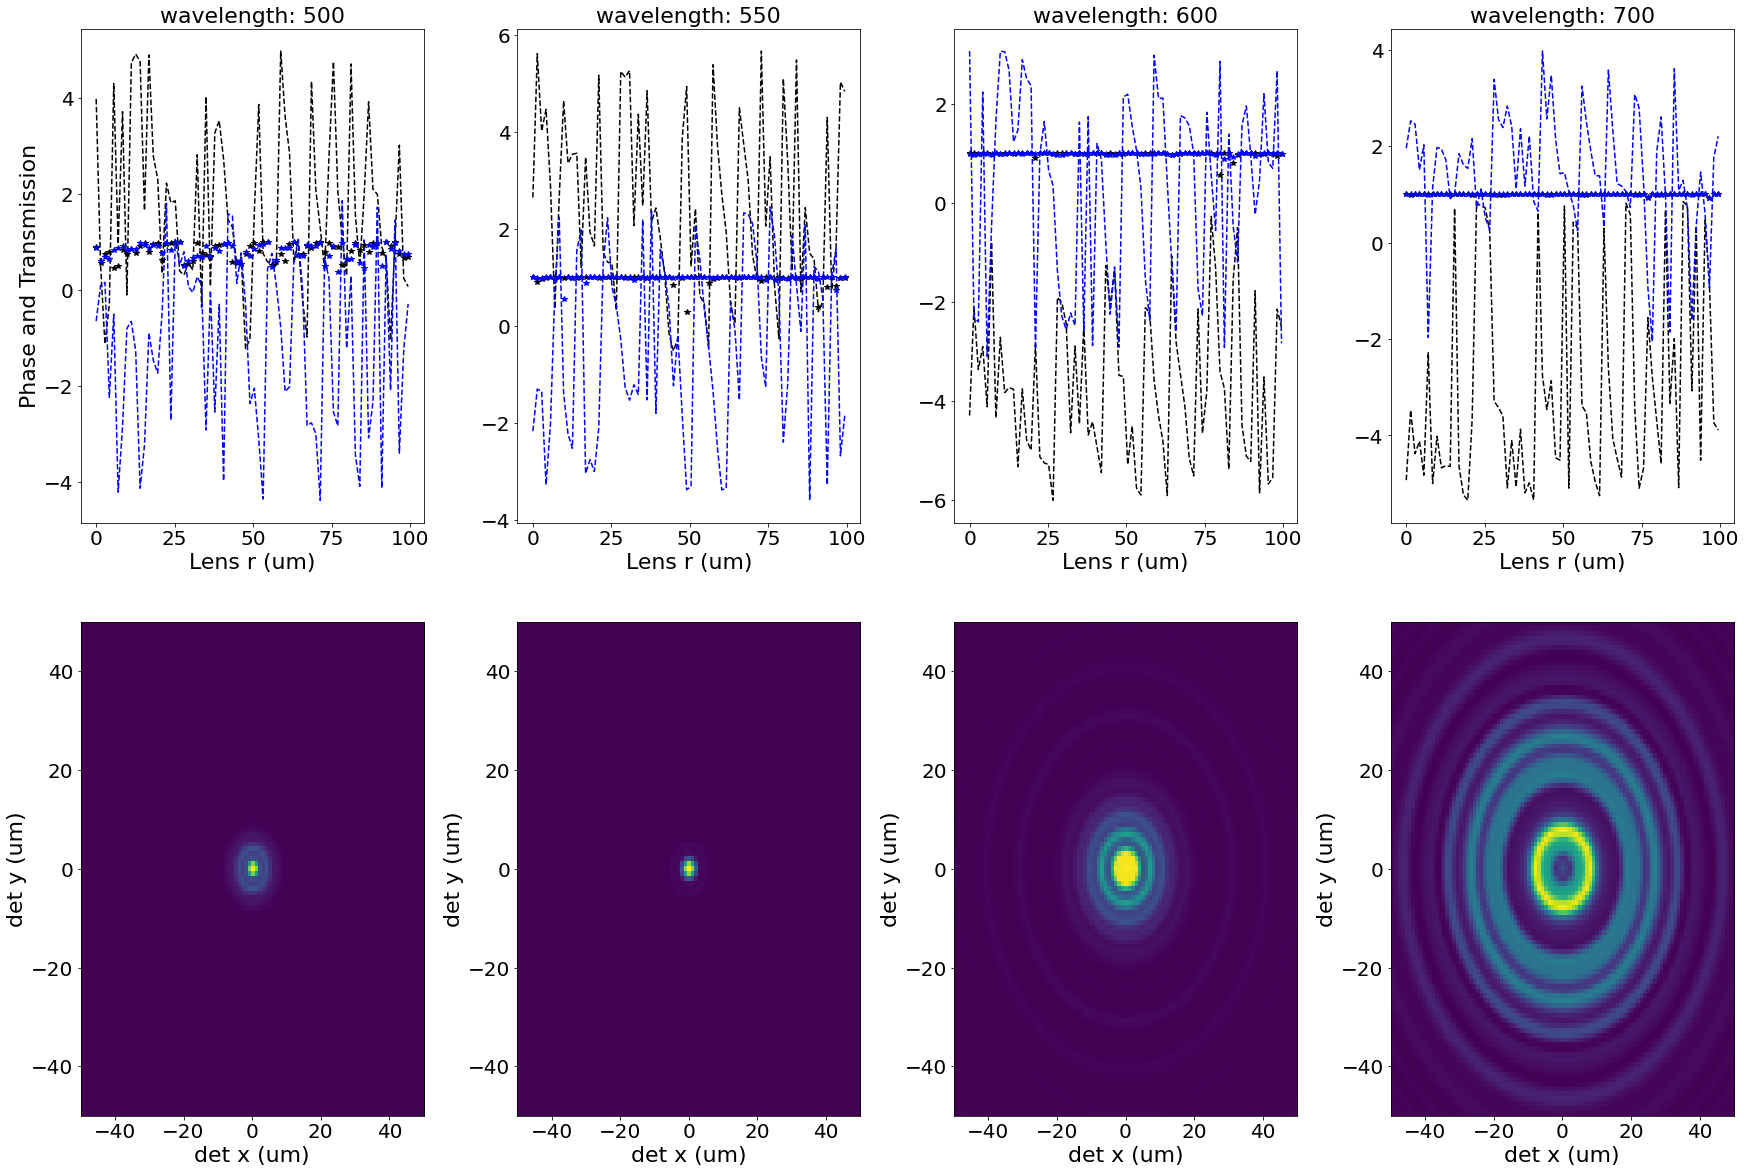

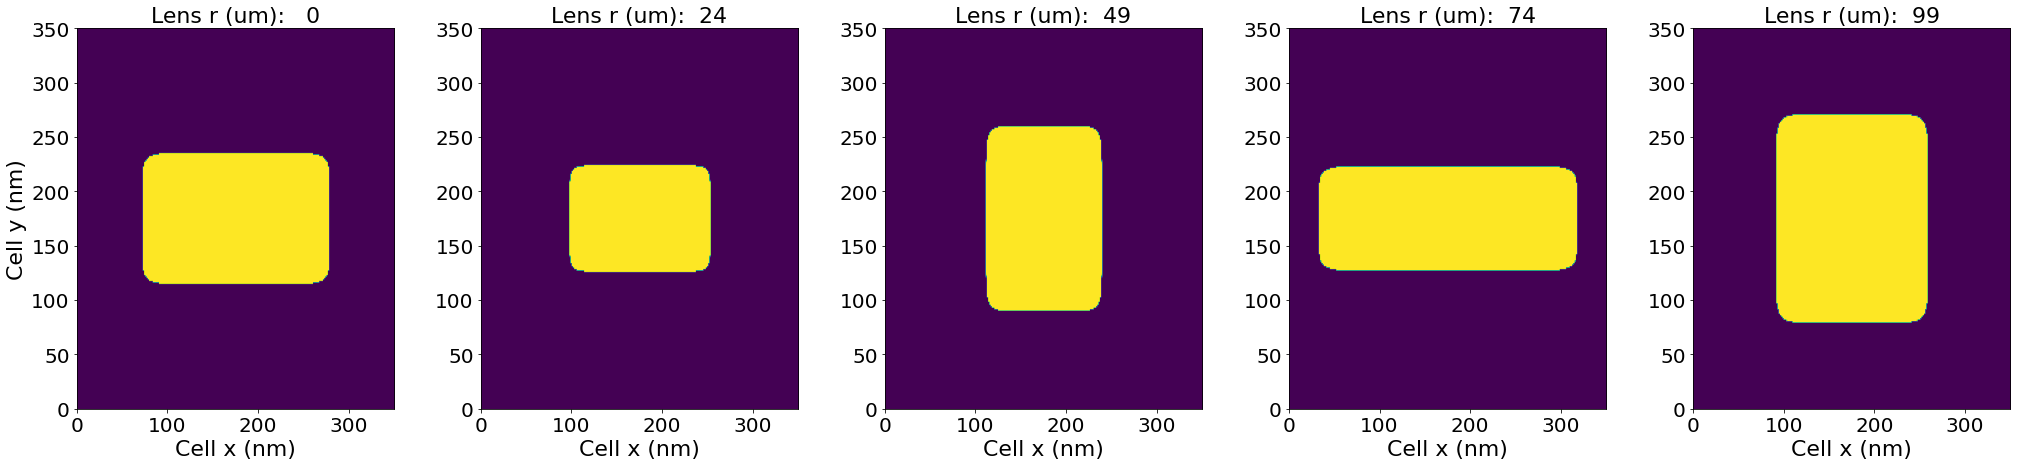

In [20]:
run_achromatic_metalens(num_epochs=20, try_gpu=True)
